<a href="https://colab.research.google.com/github/zhouziyuanjudy/PHYS417SP25/blob/main/Lab8_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 8 Report:
## FINAL PROJECT STRATEGIC PLANNING

### Lab 8 Instruction:
https://canvas.uw.edu/files/106242897/download?download_frd=1

### Team Members: Catherine Welch, Ziyuan Zhou

### Dataset for your project:
https://www.kaggle.com/competitions/galaxy-zoo-the-galaxy-challenge/


The classification and description of galaxies was previously accomplished by large-scale citizen science projects such as Galaxy Zoo. The Galaxy Zoo Challenge was a public contest in which people trained models to classify galaxies as closely to humans as possible. We will approach the same task with a convolutional neural network, leveraging its ability to pick out patterns in the image data to map features in image space to classifications made by humans.

#### dataset load


In [12]:
from PIL import Image
import os

image_folder = '/content/galaxy-data/'  # Update path if needed
broken_images = []

for filename in os.listdir(image_folder):
    if not filename.endswith('.jpg'):  # skip non-image files
        continue
    try:
        img = Image.open(os.path.join(image_folder, filename))
        img.verify()  # Check for corruption
    except Exception as e:
        broken_images.append(filename)

print("Number of corrupted images:", len(broken_images))


Number of corrupted images: 0


In [15]:
import pandas as pd

df = pd.read_csv('/content/galaxy-data/training_solutions_rev1.zip')
df['max_prob'] = df.drop('GalaxyID', axis=1).max(axis=1)

uncertain = df[df['max_prob'] < 0.6]
print("Number of uncertain labels:", len(uncertain))


Number of uncertain labels: 1188


In [22]:
import zipfile
import os

# List of zip files
zip_files = [
    '/content/galaxy-data/all_ones_benchmark.zip',
    '/content/galaxy-data/all_zeros_benchmark.zip',
    '/content/galaxy-data/central_pixel_benchmark.zip',
    '/content/galaxy-data/images_test_rev1.zip',
    '/content/galaxy-data/images_training_rev1.zip',
    '/content/galaxy-data/training_solutions_rev1.zip'
]

# Unzip each file to its own subfolder
for zip_path in zip_files:
    folder_name = os.path.splitext(os.path.basename(zip_path))[0]
    extract_to = f'/content/galaxy-data/unzipped/{folder_name}/'
    os.makedirs(extract_to, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f' Unzipped: {zip_path} → {extract_to}')


 Unzipped: /content/galaxy-data/all_ones_benchmark.zip → /content/galaxy-data/unzipped/all_ones_benchmark/
 Unzipped: /content/galaxy-data/all_zeros_benchmark.zip → /content/galaxy-data/unzipped/all_zeros_benchmark/
 Unzipped: /content/galaxy-data/central_pixel_benchmark.zip → /content/galaxy-data/unzipped/central_pixel_benchmark/
 Unzipped: /content/galaxy-data/images_test_rev1.zip → /content/galaxy-data/unzipped/images_test_rev1/
 Unzipped: /content/galaxy-data/images_training_rev1.zip → /content/galaxy-data/unzipped/images_training_rev1/
 Unzipped: /content/galaxy-data/training_solutions_rev1.zip → /content/galaxy-data/unzipped/training_solutions_rev1/


## Understanding the Data

a. Data size and structure: How big is the data? How is it structured? Are there any obvious patterns? If so, are they expected? Any unused features? Etc

The dataset includes 61,578 training images and 79,975 test images of galaxies in JPG format.

The structure is clean,  one image = one row of 37 float values in the label file.The values are between 0 and 1, showing how likely the galaxy has a certain feature.

Obvious pattern: many galaxies have strong probabilities for smooth/spiral types, which is expected based on real galaxy distributions.

No unused features. Each label column corresponds to a valid Galaxy Zoo question.

b. Data cleanness Is some of the data corrupted? Is some data mislabeled? If it's
simulated, does the simulator have any limitations

No, none of the data is corrupted.

Yes, some data might be mislabeled. I checked the label file and found that 1188 galaxies do not have a clear answer.

From dataset page it said images come from the Sloan Digital Sky Survey, a real telescope. That means the data is not simulated.

c. Diversity of features: How many features (e.g., # of pixels, # of columns) are
there per data sample? Does your dataset have approximately equal number of
datapoints per label?

In [27]:
from PIL import Image
import os

# Correct image path based on your folder structure
image_path = '/content/galaxy-data/unzipped/images_training_rev1/images_training_rev1/100008.jpg'
img = Image.open(image_path)

# Get image size and features
width, height = img.size
channels = 3 if img.mode == 'RGB' else 1

print(f"Image size: {width}x{height}")
print(f"Color mode: {img.mode}")
print(f"Total features per image: {width * height * channels}")


Image size: 424x424
Color mode: RGB
Total features per image: 539328


Each galaxy image has a size of 424×424 pixels and is in RGB color, which means each image has 3 color channels. So the total number of features per image is:
3 × 424 × 424 = 539328 features. Not balance.

Label distribution (most common class per image):
Class6.2    36706
Class1.2    15940
Class1.1     5449
Class6.1     3470
Class1.3       13
Name: count, dtype: int64


<Axes: title={'center': 'Most Common Galaxy Labels'}>

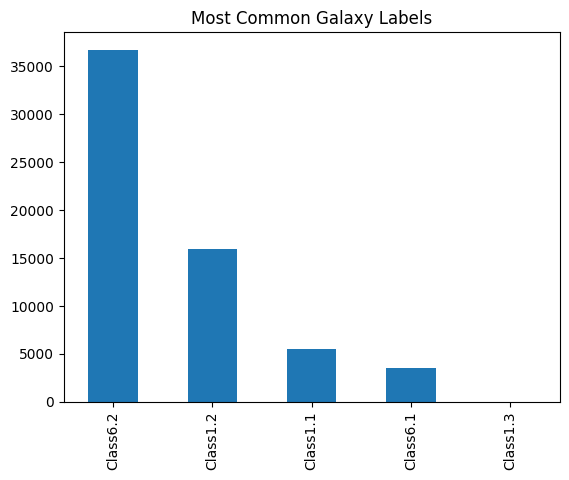

In [28]:
import pandas as pd

# Load the training labels CSV
label_path = '/content/galaxy-data/unzipped/training_solutions_rev1/training_solutions_rev1.csv'
df = pd.read_csv(label_path)

# Find the class with the highest probability for each galaxy
most_voted_class = df.drop('GalaxyID', axis=1).idxmax(axis=1)

# Count how often each label is the top vote
label_counts = most_voted_class.value_counts()

# Show the result
print("Label distribution (most common class per image):")
print(label_counts)

# Plot it to see
label_counts.plot(kind='bar', title='Most Common Galaxy Labels')


## Understanding the Task

2. Understanding the Task

a. What problem are you trying to solve with your neural network model?

 classification problem. The model takes a galaxy image and predicts a set of probabilities for different galaxy features.

b. What is the significance of solving the problem?

 Automating this process saves time compared to manual labeling by volunteers and allows scientists to analyze millions of galaxies efficiently.

c. What will be the evaluation metric for your neural network model?

We will use root-mean-square error (RMSE) or mean squared error (MSE) between the predicted probabilities.

d. What would constitute a good performance?

A good performance would mean the predicted probability distribution is very close to the true distribution.  For example, a low RMSE (closer to 0) would be considered good.

e. Is there a baseline method to compare against after meeting the performance?

Yes.

## Developing an initial plan for your project

3. Developing an initial plan for your project.

a. What will be the inputs and outputs (including their dimensions) of your neural
network model? • What data preparation methods do you plan to use?


The input is a galaxy image.
The output is a list of 37 numbers.
Each number is a probability that the galaxy has a certain feature.
Resize all images to the same size
Scale the pixel values to be between 0 and 1

b. What neural network model do you plan to use? (FCN, CNN, RNN, etc)

CNN

c. What loss function do you plan to use?

 Mean Squared Error (MSE) loss.

d. How do you plan to evaluate your model?

Root Mean Squared Error (RMSE)